In [1]:
!pip install tensorflow Keras NumPy Matplotlib opencv-python-headless

  Using cached opencv_python_headless-4.10.0.84-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
Using cached opencv_python_headless-4.10.0.84-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (49.9 MB)


In [10]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import cv2 

In [11]:
# Define image dimensions and other parameters
img_height, img_width = 48, 48
num_images = 16  # Number of images to display in the grid
grid_size = int(np.ceil(np.sqrt(num_images)))  # Grid dimensions

def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(img_height, img_width), color_mode='grayscale')
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = (img_array / 255.0) - 0.5
    return img_array

def predict_expression(img_path, model):
    img_array = load_and_preprocess_image(img_path)
    prediction = model.predict(img_array, verbose=0)
    return prediction[0]

In [12]:
# Ask user to choose the .keras model file
model_directory = './models/'  # Change this to your model directory
keras_files = [f for f in os.listdir(model_directory) if f.endswith('.keras')]
print("Available .keras model files:")
for i, file in enumerate(keras_files):
    print(f"{i + 1}. {file}")
    
choice = int(input("Enter the number corresponding to the .keras file you want to load: ")) - 1
chosen_model_file = os.path.join(model_directory, keras_files[choice])

# Load the chosen model
loaded_model = tf.keras.models.load_model(chosen_model_file)

Available .keras model files:
1. r1_model.keras
2. r2_expression_classification_model.keras
3. r1_best_model.keras
4. r1_expression_classification_model.keras
5. r2_best_model.keras
6. sentiment_best_model.keras


Enter the number corresponding to the .keras file you want to load:  1


In [13]:
# Print the model summary
print("\nModel Summary:")
loaded_model.summary()


Model Summary:


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 46, 46, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,428,567 (13.08 MB)

 Trainable params: 1,142,855 (4.36 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,285,712 (8.72 MB)

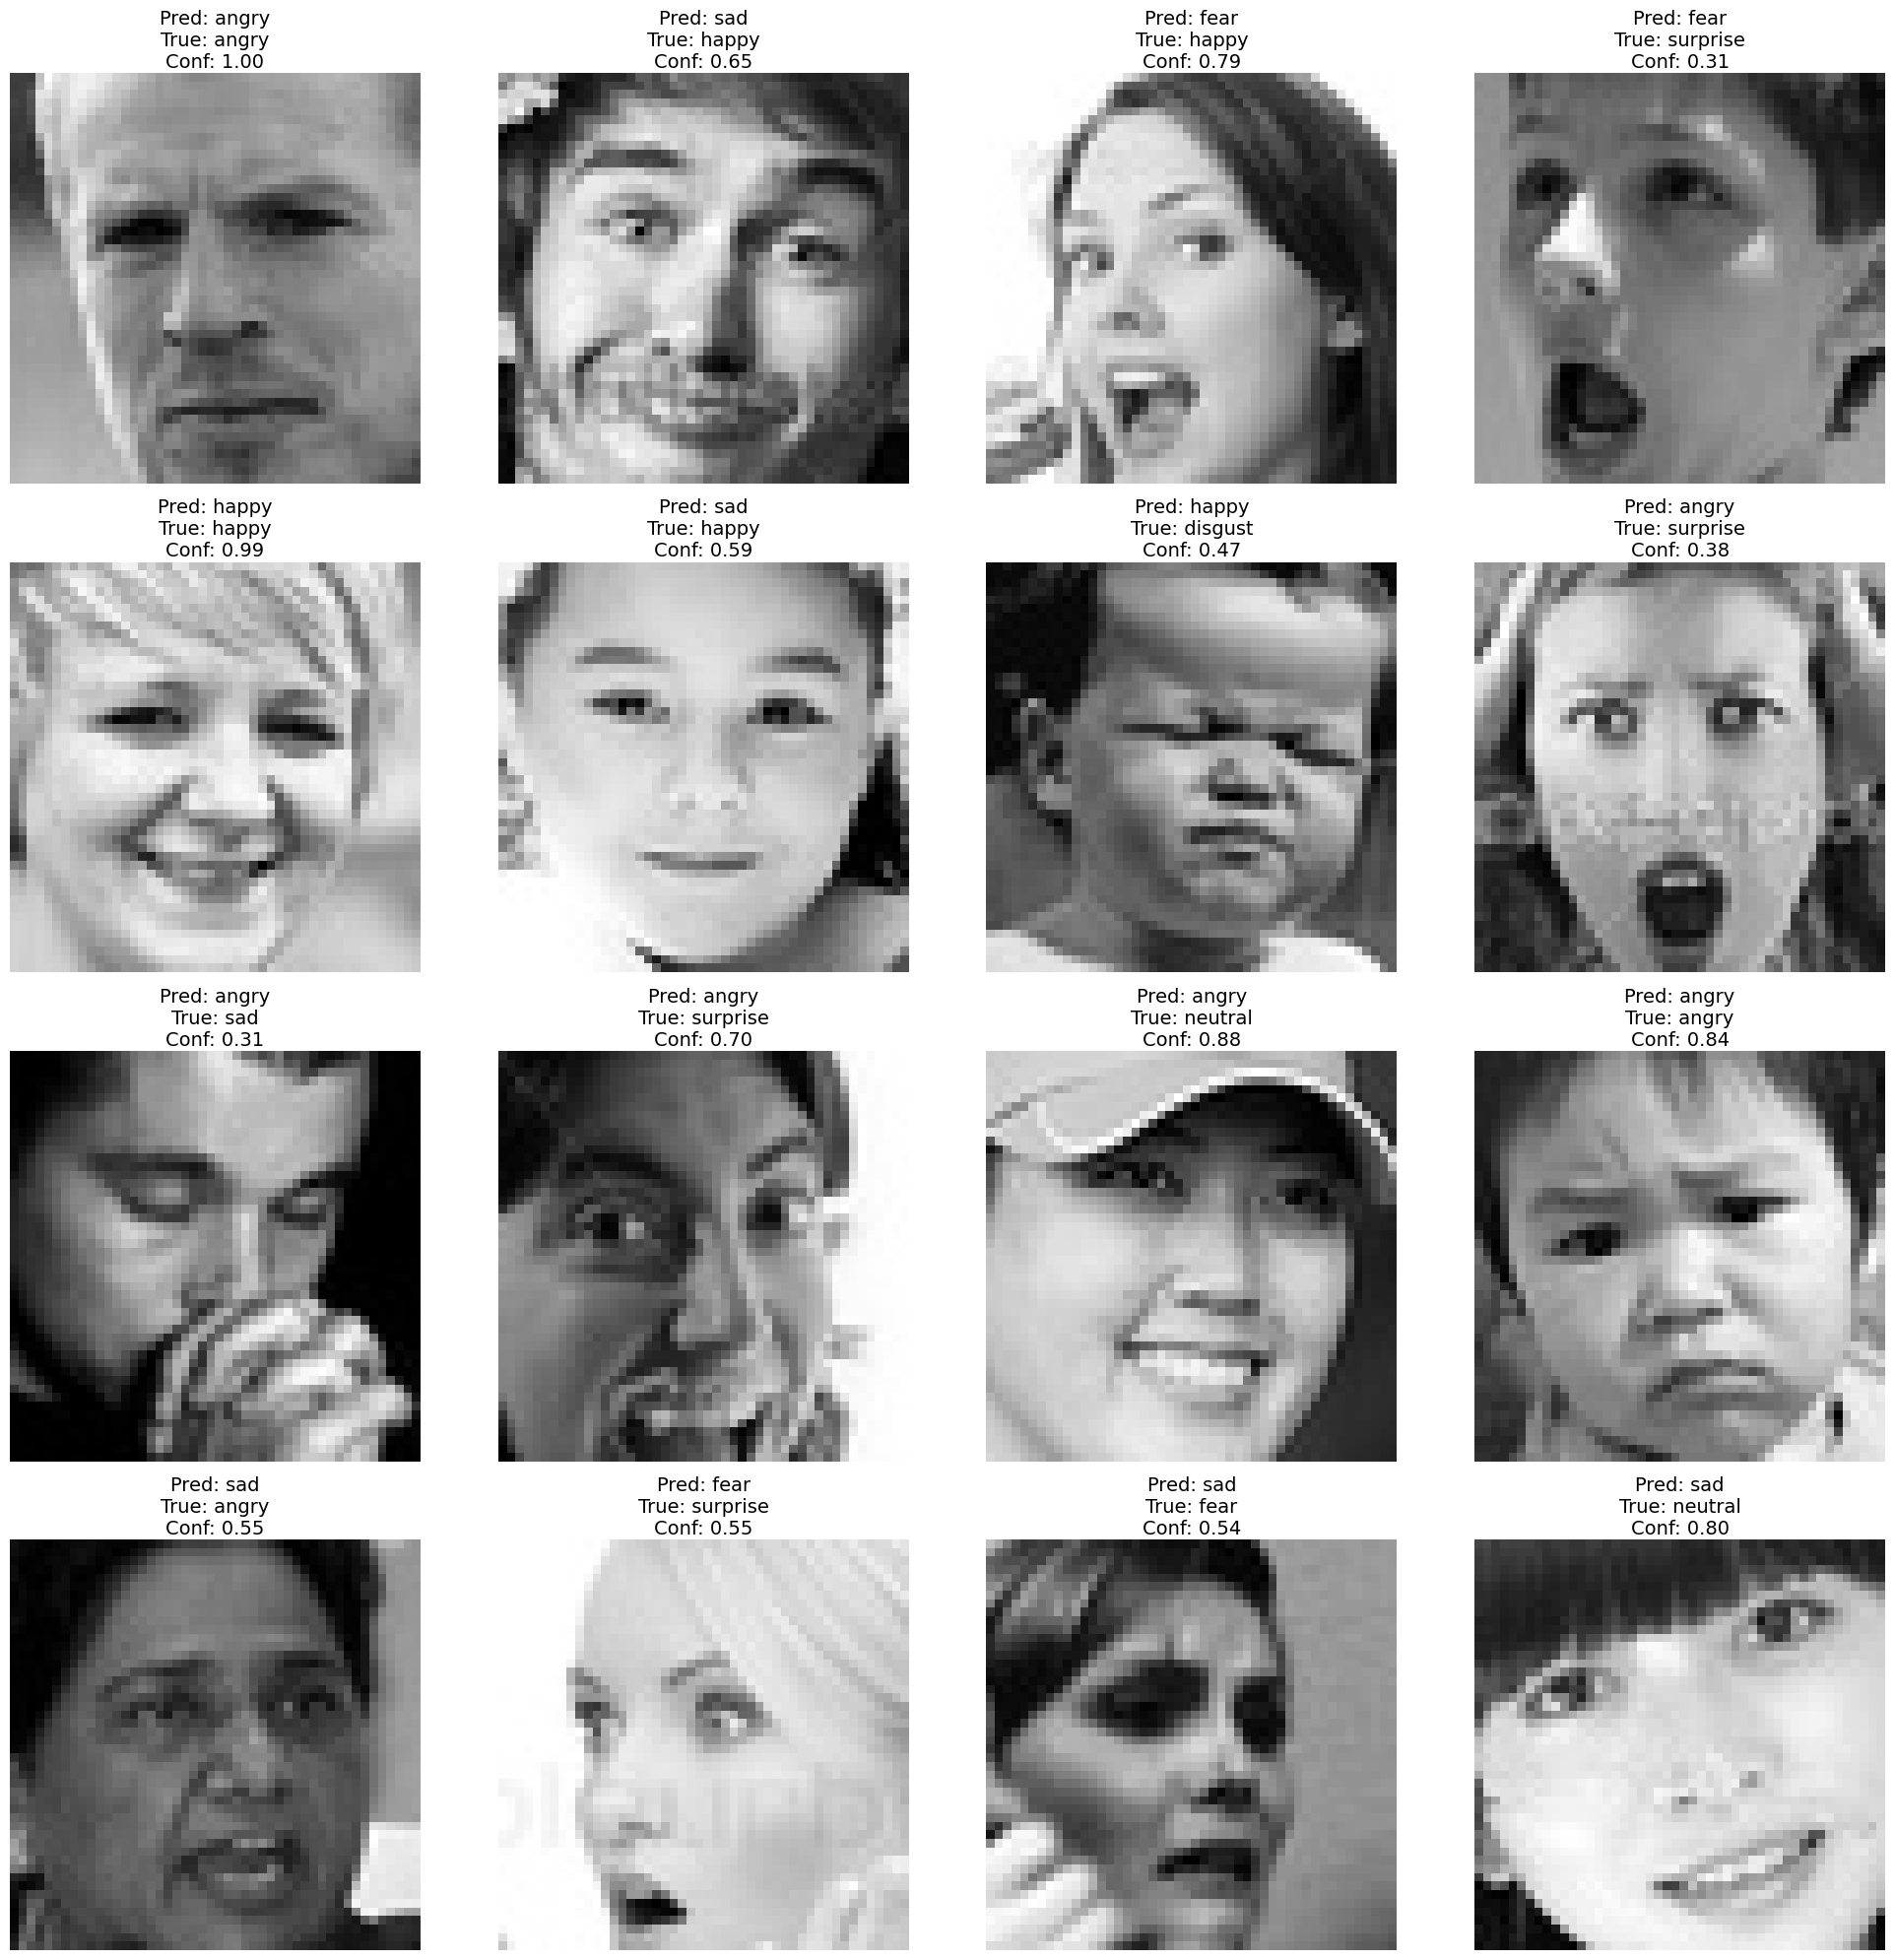

In [14]:
# Function to load and preprocess an image based on model requirements
def load_and_preprocess_image(img_path, target_size):
    # Load the image in grayscale
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    
    # Resize the image to the target size
    img_resized = cv2.resize(img, (target_size[1], target_size[0]))
    
    # If the model expects 3 channels, convert grayscale to RGB
    if target_size[2] == 3:
        img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_GRAY2RGB)
    else:
        img_rgb = img_resized[..., np.newaxis]  # Add channel dimension for grayscale

    # Normalize the image to the range [0, 1]
    img_rgb = img_rgb / 255.0
    
    # Expand dimensions to match the expected input shape for the model
    img_array = np.expand_dims(img_rgb, axis=0)
    
    return img_array

# Function to get multiple random image paths from the validation set
def get_random_image_paths(base_dir, num_images):
    image_paths = []
    true_categories = []
    categories = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
    
    for _ in range(num_images):
        random_category = random.choice(categories)
        category_path = os.path.join(base_dir, random_category)
        image_files = [f for f in os.listdir(category_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
        random_image = random.choice(image_files)
        image_paths.append(os.path.join(category_path, random_image))
        true_categories.append(random_category)
    
    return image_paths, true_categories

# Function to predict the expression from an image path
def predict_expression(img_path, model, target_size):
    img_array = load_and_preprocess_image(img_path, target_size)
    prediction = model.predict(img_array, verbose=0)
    return prediction[0]

# Parameters
base_dir = './face-expression-recognition-dataset/images/images/validation/'
num_images = 16  # Number of random images to select
grid_size = int(np.ceil(np.sqrt(num_images)))  # Calculate grid size for subplots

# Get random images from the validation set
img_paths, true_categories = get_random_image_paths(base_dir, num_images)

# Get the input shape from the model (assuming format: (height, width, channels))
input_shape = loaded_model.input_shape[1:]  # Exclude the batch size dimension

# Make predictions
predictions = [predict_expression(img_path, loaded_model, input_shape) for img_path in img_paths]

# Get the predicted classes
class_names = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
predicted_classes = [class_names[np.argmax(pred)] for pred in predictions]
confidences = [np.max(pred) for pred in predictions]

# Create a grid of subplots
fig, axes = plt.subplots(grid_size, grid_size, figsize=(20, 20))

for i, ax in enumerate(axes.flat):
    if i < num_images:
        img = plt.imread(img_paths[i])
        ax.imshow(img, cmap='gray')
        ax.axis('off')
        ax.set_title(f"Pred: {predicted_classes[i]}\nTrue: {true_categories[i]}\nConf: {confidences[i]:.2f}", 
                     fontsize=14, wrap=True)
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()

In [15]:
# Print overall accuracy
accuracy = sum([pred == true for pred, true in zip(predicted_classes, true_categories)]) / num_images
print(f"\nOverall accuracy on {num_images} random images: {accuracy:.2f}")

# Print detailed results
print("\nDetailed Results:")
for i in range(num_images):
    print(f"Image {i+1}:")
    print(f"  True category: {true_categories[i]}")
    print(f"  Predicted category: {predicted_classes[i]}")
    print(f"  Confidence: {confidences[i]:.2f}")
    print(f"  Correct: {'Yes' if predicted_classes[i] == true_categories[i] else 'No'}")
    print()


Overall accuracy on 16 random images: 0.19

Detailed Results:
Image 1:
  True category: angry
  Predicted category: angry
  Confidence: 1.00
  Correct: Yes

Image 2:
  True category: happy
  Predicted category: sad
  Confidence: 0.65
  Correct: No

Image 3:
  True category: happy
  Predicted category: fear
  Confidence: 0.79
  Correct: No

Image 4:
  True category: surprise
  Predicted category: fear
  Confidence: 0.31
  Correct: No

Image 5:
  True category: happy
  Predicted category: happy
  Confidence: 0.99
  Correct: Yes

Image 6:
  True category: happy
  Predicted category: sad
  Confidence: 0.59
  Correct: No

Image 7:
  True category: disgust
  Predicted category: happy
  Confidence: 0.47
  Correct: No

Image 8:
  True category: surprise
  Predicted category: angry
  Confidence: 0.38
  Correct: No

Image 9:
  True category: sad
  Predicted category: angry
  Confidence: 0.31
  Correct: No

Image 10:
  True category: surprise
  Predicted category: angry
  Confidence: 0.70
  Corr

# convert model

In [9]:
# Check its architecture
loaded_model.summary()

#Save the model into h5 format
loaded_model.save('models/r1_model.h5')

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 72,232,072 (275.54 MB)

 Trainable params: 24,059,650 (91.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

 Optimizer params: 48,119,302 (183.56 MB)